In [9]:
import matplotlib.pyplot as plt
import numpy as np

import nengo
import scipy.linalg
from scipy.special import legendre

from ldn_neurons_basic import LDN_RNN

In [10]:
with nengo.Network() as model:
    q = 11
    theta = 0.5
    
    input_ = nengo.Node(nengo.processes.WhiteSignal(1., high=5, seed=42))
    #input_ = nengo.Node( lambda t: np.sin(100*t) )
    #input = nengo.Node( lambda t: t % 1. )
    ldn_rnn = LDN_RNN( q = q, size_in = 1, theta = theta, neuron_type = nengo.Tanh() )
    output = nengo.Node(None, size_in=1)
    
    nengo.Connection(input_, ldn_rnn.input, synapse=None)
    nengo.Connection(ldn_rnn.rec, output, synapse=None, transform=ldn_rnn.get_weights_for_delays([1.0]))
    
    in_p = nengo.Probe(input_)
    out_p = nengo.Probe(output)
    
    # inject current into recurrent population to mimic loss of inhibition
    inj = nengo.Node( lambda t: t//1./10 if t<10 else 1.-(t-10.)//1./10)
    nengo.Connection(inj,ldn_rnn.rec.neurons,transform = np.ones((1000,1)) )
    inj_p = nengo.Probe(inj)

with nengo.Simulator(model) as sim:
    sim.run(30.)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

In [11]:
import nengo_gui.jupyter
nengo_gui.jupyter.InlineGUI(model, cfg='neuromdulating_ldn.cfg')

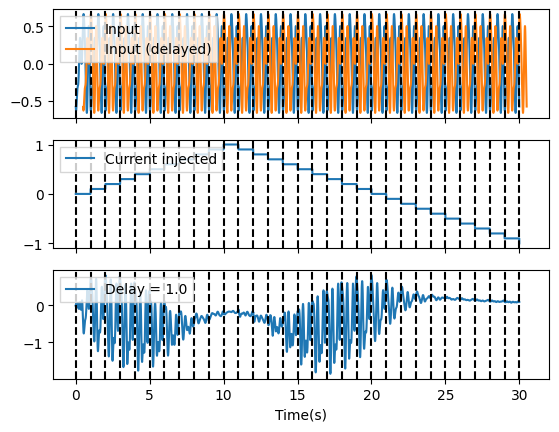

In [12]:
import pandas as pd
df = pd.DataFrame( data = {
    'time'    : sim.trange(),
    'input'   : sim.data[in_p].flatten(),
    'current' : sim.data[inj_p].flatten(),
    'output'  : sim.data[out_p].flatten()
    }
)

fig,axs = plt.subplots(3,1,sharex=True)
axs[0].plot(df['time'],df['input'],label='Input')
axs[0].plot(df['time']+0.5,df['input'],label='Input (delayed)')
axs[1].plot(df['time'],df['current'],label='Current injected')
axs[2].plot(df['time'],df['output'],label='Delay = 1.0')
for ax in axs.ravel():
    ax.legend(loc='upper left',fancybox=False)
    for t in np.linspace( 0, sim.trange().max(), 31):
        ax.axvline(t,color='k',linestyle='--')
ax.set_xlabel('Time(s)')
plt.show()

1000


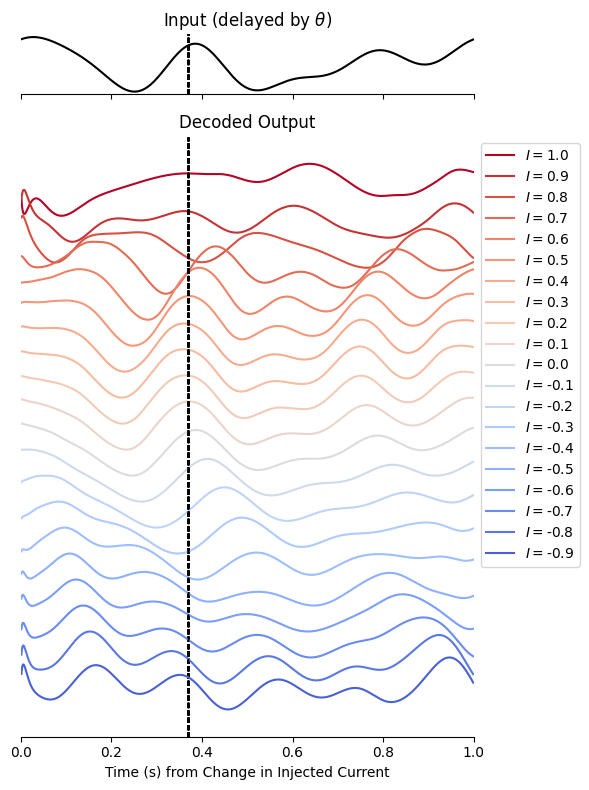

In [14]:
SR = int(1/df['time'].diff().mean())
print(SR)

from matplotlib import cm
cmap = cm.coolwarm

fig,(ax1,ax2) = plt.subplots(2,1, sharex = True,
                             figsize = (6.,8.), gridspec_kw = {'height_ratios':[1,10]}
                            )
df['input'] = (df['input'] - df['input'].min()) / (df['input'].max() - df['input'].min())
ax1.plot(df['time']-0.5,df['input'],color='k')

ts = [t for t in range(10,30)]

cs = df['current'].unique().tolist()
for t in ts:
    idx_min = t*SR
    idx_max = (t+1)*SR
    subdf = df[ (df['time'] > t) & (df['time']<t+1) ].reset_index(drop=True)
    subdf['time'] -= t
    current = subdf['current'].mean()
    
    for ax in (ax1,ax2):        
        # some arbitrary peak in the signal to compare between injected currents
        ax.axvline(0.37,color='k',linestyle='--',linewidth=1.)

    color = cmap( (current+1.)/2 ) # scale to within [0.,1.]
    subdf['output'] = (subdf['output'] - subdf['output'].min()) / (subdf['output'].max() - subdf['output'].min())
    subdf['output'] *= 2

    ax2.plot(subdf['time'],subdf['output']+current*10,c=color,label = r'$I = $' + f'{round(current,2)}')
for ax in (ax1,ax2):
    for spine in ['top','right','left']:
        ax.spines[spine].set_visible(False)
        ax.set_yticks([])

ax1.set_xlim(0.,1.)
ax1.set_title(r'Input (delayed by $\theta$)')

ax2.set_title('Decoded Output')
ax2.set_xlabel('Time (s) from Change in Injected Current')
ax2.legend(loc='upper left',bbox_to_anchor=(1, 1.))
fig.tight_layout()
plt.show()